 # Pre-processing

In [1]:
#TODO - Apply image segmentation before classification, 
#https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import os
import random
import glob
import itertools
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
%matplotlib inline

TRAIN_DIR = 'data/train'
VAL_DIR = 'data/val'
TEST_DIR = 'data/test'
NO_PNEUMONIA = 0
PNEUMONIA = 1
IMG_DIMEN = 224
BATCH_SIZE = 16
RGB_CHANNELS = 3
random.seed(1234)

/Users/kkoehncke/anaconda/envs/standard_3_6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
#Code excerpt from Keras
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [2]:
#Let's examine how many images comprise our training set
#We use the following convention
#
#0 = No Pneumonia
#1 = Pneumonia

def read_images(directory):
    X = []
    y = []
    normal_imgs = glob.glob(directory + '/NORMAL/*.jpeg')
    infected_imgs = glob.glob(directory + '/PNEUMONIA/*.jpeg')
    for img in normal_imgs:
        read_img = load_img(img, target_size=(IMG_DIMEN, IMG_DIMEN, RGB_CHANNELS))
        X.append(img_to_array(read_img))
        y.append(NO_PNEUMONIA)
    for img in infected_imgs:
        read_img = load_img(img, target_size=(IMG_DIMEN, IMG_DIMEN, RGB_CHANNELS))
        X.append(img_to_array(read_img))
        y.append(PNEUMONIA)
    return np.asarray(X, dtype=np.float32), to_categorical(np.asarray(y, dtype=np.float32), num_classes=2)

In [3]:
X_train, y_train = read_images(TRAIN_DIR)
X_validation, y_validation = read_images(VAL_DIR)
X_test, y_test = read_images(TEST_DIR)

In [4]:
#Let's see a few images of our classes 

infected_imgs  =  os.listdir(TRAIN_DIR + "/PNEUMONIA")
non_infected_imgs = os.listdir(TRAIN_DIR + "/NORMAL")

#Function that will randomly choose n images and display
def show_imgs(n):
    _, ax = plt.subplots(n,2, figsize=(10,30))
    for row_n in range(n):
        i = random.randrange(0, len(X_train[0]))
        img_p = load_img(TRAIN_DIR + "/PNEUMONIA/" + infected_imgs[i], target_size=(IMG_DIMEN, IMG_DIMEN))
        img_n = load_img(TRAIN_DIR+"/NORMAL/"+ non_infected_imgs[i], target_size=(IMG_DIMEN, IMG_DIMEN))
        ax[row_n, 0].imshow(img_p)
        ax[row_n, 0].set_xlabel('Class: Pneumonia')
        ax[row_n, 1].imshow(img_n)
        ax[row_n, 1].set_xlabel('Class: No Pneumonia')

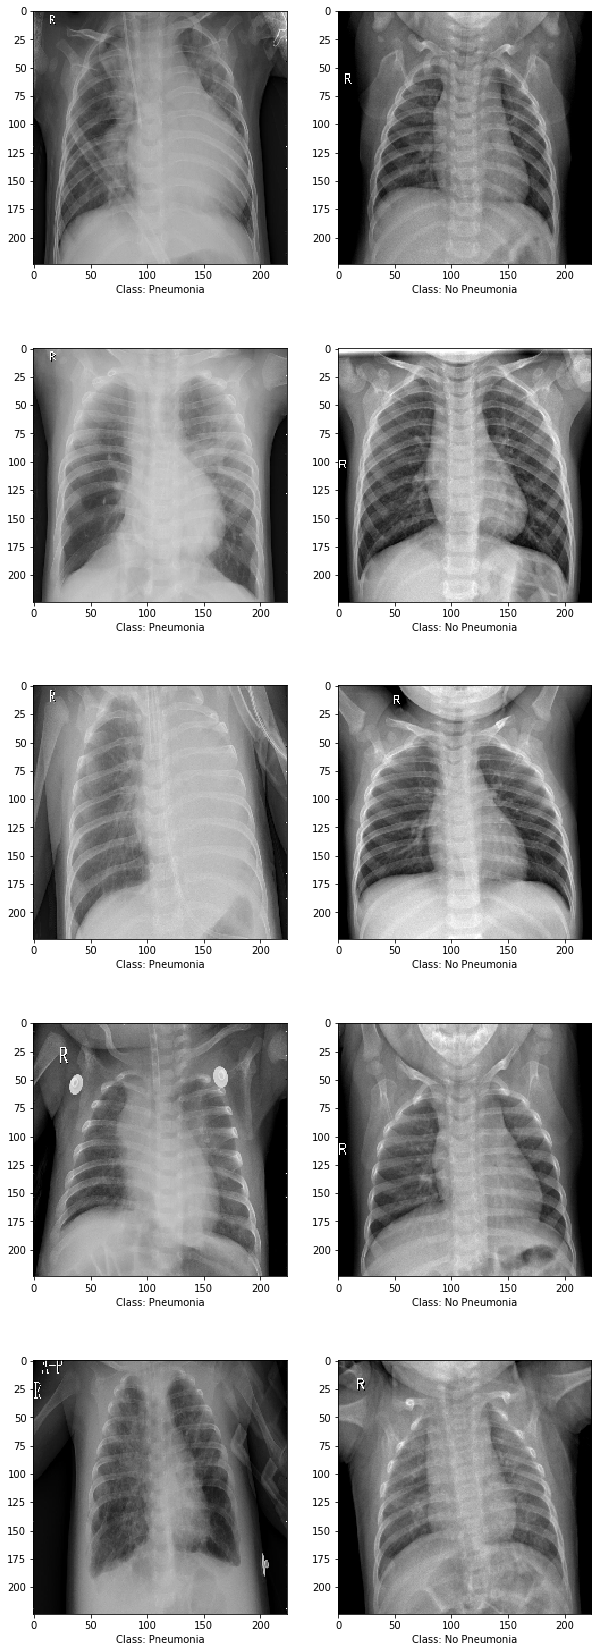

In [5]:
show_imgs(5)

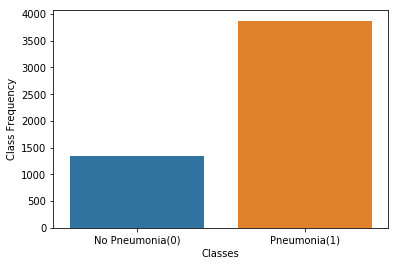

In [6]:
#Let's examine the distribution of our binary classes for our training set
count_classes = np.sum(y_train, axis = 0)
sns.barplot(x = ['No Pneumonia(0)', 'Pneumonia(1)'], y = count_classes)
plt.ylabel('Class Frequency')
plt.xlabel('Classes')
plt.show()

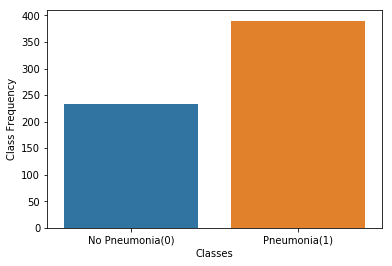

In [7]:
#Let's examine the distribution of our binary classes for our testing set
count_classes = np.sum(y_test, axis = 0)
sns.barplot(x = ['No Pneumonia(0)', 'Pneumonia(1)'], y = count_classes)
plt.ylabel('Class Frequency')
plt.xlabel('Classes')
plt.show()

# Model 

In [8]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_ints)
feed_class_weights = {0: class_weights[0],
                      1: class_weights[1]}

In [9]:
#Define our image augmentator 
train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [10]:
#Define our InceptionV3 Model & apply transfer learning
#input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_shape=(IMG_DIMEN, IMG_DIMEN, RGB_CHANNELS), weights='imagenet', 
                         include_top=False)
#Build our FC layers
#TODO - Tune layer # and activation fnct
x = base_model.output
#x = MaxPooling2D((2,2), name='pool_output')(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='FC_1024')(x)
x = Dropout(0.7, name='Dropout_1')(x)
x = Dense(512, activation='relu', name='FC_512')(x)
x = Dropout(0.3, name='Dropout_2')(x)
predictions = Dense(2, activation='softmax', name='FC_output')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
#Let's first train our newly added FC layers.
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = Adam(lr=0.0001, decay=1e-5), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [13]:
epochs = 5
train_data_gen.fit(X_train)

In [14]:
model.fit_generator(train_data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data = test_data_gen.flow(X_validation, y_validation, batch_size=BATCH_SIZE),
                    shuffle = True, steps_per_epoch = X_train.shape[0] // BATCH_SIZE, epochs = epochs,
                    class_weight = feed_class_weights)

Epoch 1/5
326/326 [==============================] - 686s 2s/step - loss: 1.1578 - acc: 0.7297 - val_loss: 0.6385 - val_acc: 0.5625
Epoch 2/5
326/326 [==============================] - 676s 2s/step - loss: 0.4582 - acc: 0.8073 - val_loss: 0.5548 - val_acc: 0.7500
Epoch 3/5
326/326 [==============================] - 678s 2s/step - loss: 0.4078 - acc: 0.8259 - val_loss: 0.5508 - val_acc: 0.6875
Epoch 4/5
326/326 [==============================] - 664s 2s/step - loss: 0.3898 - acc: 0.8401 - val_loss: 0.6380 - val_acc: 0.6875
Epoch 5/5
326/326 [==============================] - 674s 2s/step - loss: 0.3758 - acc: 0.8422 - val_loss: 1.3613 - val_acc: 0.5000


In [25]:
#Code excerpt from Scikit-Learn
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [28]:
#Helper function that evaluates our model, plots the confusion matrix,
#and calculates precision and recall
def test_model(model, X_test, y_test):
    test_loss, test_score = model.evaluate_generator(test_data_gen.flow(
                            X_test, y_test, batch_size=BATCH_SIZE))
    
    print("Test Loss: ", test_loss)
    print("Test Accuracy: ", test_score)
    
    # Get predictions
    y_pred = model.predict_generator(test_data_gen.flow(X_test, batch_size=BATCH_SIZE))
    y_pred = np.argmax(preds, axis=-1)
    y_true = np.argmax(y_test, axis=-1)
    
    # Get the confusion matrix
    cm  = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, ['No Pneumonia', 'Pneumonia'])
    
    # Calculate Precision and Recall
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    print("Recall of the model is {:.2f}".format(recall))
    print("Precision of the model is {:.2f}".format(precision))

In [ ]:
test_model(model, X_test, y_test)

# Model Iteration 2

In [22]:
#We want to train the third Inception block on our medical images
#to try and capture some of the distinct features
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
model.compile(optimizer = Adam(lr=0.0001, decay=1e-5), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
epochs = 20
model.fit_generator(train_data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data = test_data_gen.flow(X_validation, y_validation, batch_size=BATCH_SIZE),
                    shuffle = True, steps_per_epoch = X_train.shape[0] // BATCH_SIZE, epochs = epochs,
                    class_weight = feed_class_weights)

Epoch 1/10
326/326 [==============================] - 833s 3s/step - loss: 0.3697 - acc: 0.8867 - val_loss: 5.9427 - val_acc: 0.5000
Epoch 2/10
326/326 [==============================] - 812s 2s/step - loss: 0.2647 - acc: 0.9224 - val_loss: 6.9711 - val_acc: 0.5000
Epoch 3/10
326/326 [==============================] - 838s 3s/step - loss: 0.2200 - acc: 0.9342 - val_loss: 7.8041 - val_acc: 0.5000
Epoch 4/10
326/326 [==============================] - 822s 3s/step - loss: 0.1778 - acc: 0.9352 - val_loss: 4.5095 - val_acc: 0.5000
Epoch 5/10
326/326 [==============================] - 835s 3s/step - loss: 0.1869 - acc: 0.9469 - val_loss: 2.1502 - val_acc: 0.5625
Epoch 6/10
326/326 [==============================] - 819s 3s/step - loss: 0.1636 - acc: 0.9450 - val_loss: 3.8857 - val_acc: 0.5000
Epoch 7/10
326/326 [==============================] - 815s 3s/step - loss: 0.1570 - acc: 0.9494 - val_loss: 5.5632 - val_acc: 0.5000
Epoch 8/10
326/326 [==============================] - 826s 3s/step - 

Test Loss:  2.769096369926746
Test Accuracy:  0.6762820512820513
[[ 14 220]
 [ 20 370]]
Recall of the model is 0.95
Precision of the model is 0.63


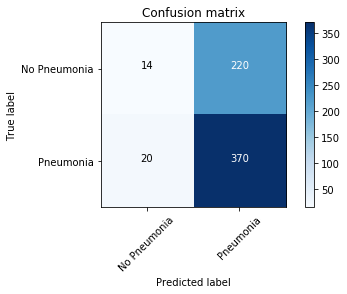

In [27]:
test_model(model, X_test, y_test)